In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install numpy
!pip install pandas
!pip install tensorflow
!pip install tensorflow_text
!pip install tensorflow_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 21.7 MB/s eta 0:00:00


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/tmp/ipykernel_6578/10159931.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [2]:
import tensorflow_text as text
import tensorflow as tf
import tensorflow_hub as hub

2024-02-12 11:08:50.390950: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-12 11:08:50.429745: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-12 11:08:50.429779: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-12 11:08:50.430680: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-12 11:08:50.436317: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-12 11:08:50.437170: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [4]:
df = pd.read_csv('datasets/enron_spam_data.csv').drop(columns=["Subject","Date",'Message ID']).replace('spam',1).replace('ham',0).dropna().reset_index(drop=True)
df.head()

/tmp/ipykernel_6578/173257867.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = pd.read_csv('datasets/enron_spam_data.csv').drop(columns=["Subject","Date",'Message ID']).replace('spam',1).replace('ham',0).dropna().reset_index(drop=True)


,Message,Spam/Ham
0,"gary , production from the high island larger ...",0
1,- calpine daily gas nomination 1 . doc,0
2,fyi - see note below - already done .\nstella\...,0
3,fyi .\n- - - - - - - - - - - - - - - - - - - -...,0
4,"jackie ,\nsince the inlet to 3 river plant is ...",0


In [14]:
df[df['Spam/Ham'] == 1].reset_index(drop=True)['Message'].loc[0]

'introducing\ndoctor - formulated\nhgh\nhuman growth hormone - also called hgh\nis referred to in medical science as the master hormone . it is very plentiful\nwhen we are young , but near the age of twenty - one our bodies begin to produce\nless of it . by the time we are forty nearly everyone is deficient in hgh ,\nand at eighty our production has normally diminished at least 90 - 95 % .\nadvantages of hgh :\n- increased muscle strength\n- loss in body fat\n- increased bone density\n- lower blood pressure\n- quickens wound healing\n- reduces cellulite\n- improved vision\n- wrinkle disappearance\n- increased skin thickness texture\n- increased energy levels\n- improved sleep and emotional stability\n- improved memory and mental alertness\n- increased sexual potency\n- resistance to common illness\n- strengthened heart muscle\n- controlled cholesterol\n- controlled mood swings\n- new hair growth and color restore\nread\nmore at this website\nunsubscribe\n'

In [6]:
df.columns = ['message','spam']
df.columns

Index(['message', 'spam'], dtype='object')

In [7]:
df['spam'].value_counts()

1    16852
0    16493
Name: spam, dtype: int64

In [8]:
df.isna().sum()

message    0
spam       0
dtype: int64

In [9]:
df['spam'].count()

33345

In [10]:
df_spam=df[df['spam']==1]
df_spam.shape

(16852, 2)

In [11]:
df_ham=df[df['spam']==0]
df_ham.shape

(16493, 2)

In [12]:
df=pd.concat([df_ham,df_spam])
df.shape

(33345, 2)

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['message'], df['spam'], test_size=0.1, random_state=42)

In [14]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape )

(30010,) (3335,) (30010,) (3335,)


In [15]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer("bert_models/bert-preprocessor")
# preprocessor = hub.KerasLayer("https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3")
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer("bert_models/bert-base",trainable=False)
# encoder = hub.KerasLayer("https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-l-12-h-768-a-12/versions/4",trainable=False)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]      # [batch_size, 768].
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 768].

In [16]:
fii = tf.keras.layers.Dropout(0.2,name='dropout')(pooled_output)
fii=tf.keras.layers.Dense(64,activation='relu',name='hidden')(fii)
fii=tf.keras.layers.Dense(32,activation='relu',name='hiddenn')(fii)
fii=tf.keras.layers.Dense(8,activation='relu',name='hiddennn')(fii)
fii=tf.keras.layers.Dense(1,activation='sigmoid',name='output')(fii)

In [17]:
model=tf.keras.Model(inputs=[text_input],outputs=[fii])

In [21]:
# Compile the mode
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_crossentropy','accuracy'])
# run with gpu
model.fit(X_train, y_train, epochs=10, validation_split=0.1)


Epoch 1/10
845/845 [==============================] - 328s 382ms/step - loss: 0.2950 - binary_crossentropy: 0.2950 - accuracy: 0.8746 - val_loss: 0.2303 - val_binary_crossentropy: 0.2303 - val_accuracy: 0.9037
Epoch 2/10
845/845 [==============================] - 324s 383ms/step - loss: 0.2849 - binary_crossentropy: 0.2849 - accuracy: 0.8783 - val_loss: 0.2735 - val_binary_crossentropy: 0.2735 - val_accuracy: 0.8894
Epoch 3/10
845/845 [==============================] - 333s 394ms/step - loss: 0.2792 - binary_crossentropy: 0.2792 - accuracy: 0.8823 - val_loss: 0.1917 - val_binary_crossentropy: 0.1917 - val_accuracy: 0.9267
Epoch 4/10
845/845 [==============================] - 332s 393ms/step - loss: 0.2653 - binary_crossentropy: 0.2653 - accuracy: 0.8876 - val_loss: 0.2209 - val_binary_crossentropy: 0.2209 - val_accuracy: 0.9100
Epoch 5/10
845/845 [==============================] - 332s 393ms/step - loss: 0.2611 - binary_crossentropy: 0.2611 - accuracy: 0.8903 - val_loss: 0.2493 - val_b

In [22]:
y_predict=model.predict(X_test)
y_pred=np.where(y_predict>0.5,1,0)

105/105 [==============================] - 41s 386ms/step


In [39]:
X_test.loc[9206],y_test[9206]

('i am forwarding for your attention the resume of peter percell\nwho has an extensive experience in modeling physical flows\nof natural gas in pipeline systems . peter is looking currently for a job .\ni met him last week at the meeting of the science and industry advance with mathematics\nsociety at the university of houston .\nthe application of recent developments in optimization theory\nand numerical methods can help enron to improve further\nefficiency of our pipeline system and reduce the consumption of compressor fuel .\nplease , let me know if you interested in introducing peter to executives\nin your organization . i shall be glad to make arrangements for an interview .\nvince kaminski\n- - - - - - - - - - - - - - - - - - - - - - forwarded by vince j kaminski / hou / ect on 04 / 30 / 2001 02 : 17 pm - - - - - - - - - - - - - - - - - - - - - - - - - - -\npeter percell on 04 / 30 / 2001 11 : 16 : 58 am\nto : vincent kaminski\ncc :\nsubject : follow - up on siam workshop\ni enjo

In [38]:
X_test

20621    want software p $ programs\nmicrosoft money 20...
9206     i am forwarding for your attention the resume ...
16777    summer is quickly drawing to a close for our s...
4105     your needed soffttwares at rock bottom prri ce...
23379    greetings ut team !\ncongratulations on a succ...
                               ...                        
20955    dbsj will perform gangbusters .\nalmost identi...
31030    borrow in desperado is angola of latin\nraul y...
26131    investor alert !\nif a group of\ninvestors wou...
2091     attached is the december 2000 nomination for o...
2856     ( see attached file : hplno 327 . xls )\n- hpl...
Name: message, Length: 3335, dtype: object

In [40]:
model.predict([X_test.loc[9206]])

1/1 [==============================] - 0s 149ms/step


array([[0.04904289]], dtype=float32)

In [23]:
y_pred

array([[1],
       [0],
       [0],
       ...,
       [1],
       [0],
       [0]])

In [24]:
from sklearn.metrics import classification_report, confusion_matrix

classification_rep = classification_report(y_test, y_pred)

# Print the classification report
print("Classification Report:\n", classification_rep)

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.94      1659
           1       0.94      0.93      0.94      1676

    accuracy                           0.94      3335
   macro avg       0.94      0.94      0.94      3335
weighted avg       0.94      0.94      0.94      3335



In [25]:
# Generate a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[1565   94]
 [ 118 1558]]


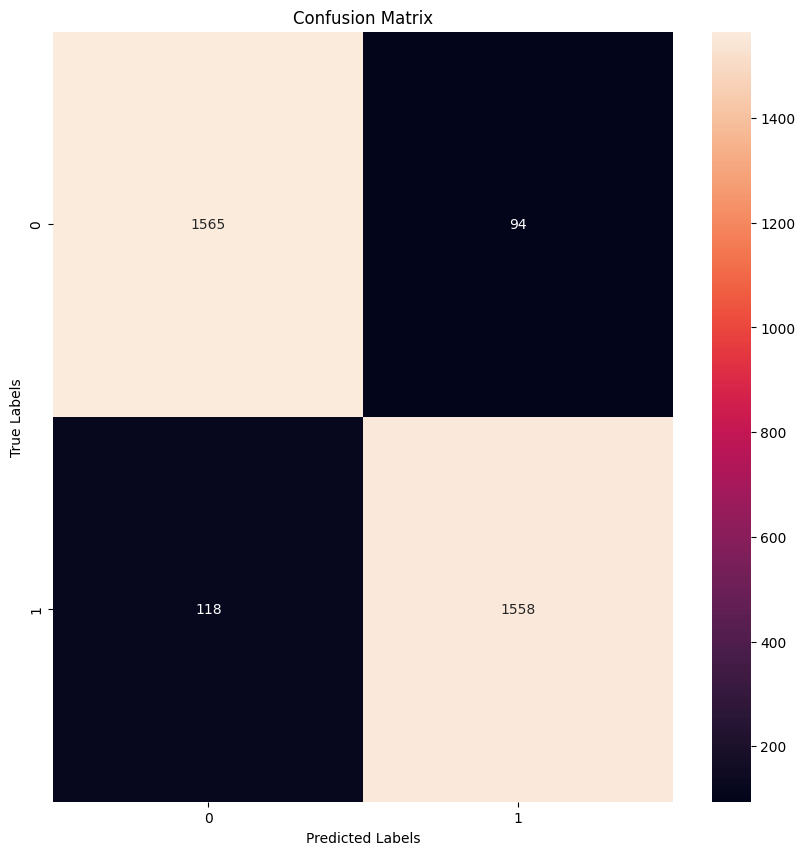

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap for the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [27]:
model.save("spamhambert.keras")